# AI Term Project #3

Name: Quentin Ducoulombier  
Student id: 312551811

## Import

In [1]:
# For data manipulation
import pandas as pd
import numpy as np

# For machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import f1_score, matthews_corrcoef, roc_auc_score, confusion_matrix
from sklearn.impute import SimpleImputer

# For plot styling
import matplotlib.pyplot as plt
import seaborn as sns

## Load the data

In [2]:
train_X = pd.read_excel('./train_X.xlsx')
train_y = pd.read_excel('./train_y.xlsx')

## Preprocessing

In [3]:
# Assuming the target variable is named 'Deadin_D14' in train_y
train_y = train_y['Deadin_D14']

# Extract and clean column names
cleaned_columns = [col.strip() for col in train_X.columns]
train_X.columns = cleaned_columns

# Automatically detect numeric features
numeric_features = train_X.select_dtypes(include=[np.number]).columns.tolist()

# Scale numeric features
scaler = StandardScaler()
train_X[numeric_features] = scaler.fit_transform(train_X[numeric_features])

# Impute missing values with the median strategy
imputer = SimpleImputer(strategy='median')
train_X_imputed = pd.DataFrame(imputer.fit_transform(train_X), columns=train_X.columns)

# Split the imputed data
X_train_imputed, X_val_imputed, y_train_imputed, y_val_imputed = train_test_split(train_X_imputed, train_y, test_size=0.2, random_state=42)

## Random Forest

In [4]:
# Define the RandomForest classifier with specified hyperparameters
rf_model = RandomForestClassifier(
    bootstrap=False,
    max_depth=10,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=100,
    random_state=42
)

# Train the model
rf_model.fit(X_train_imputed, y_train_imputed)


RandomForestClassifier(bootstrap=False, max_depth=10, random_state=42)

### Select the most important features for the Random Forest

Selected important features: ['Unnamed: 0', 'Age', 'Days after index(Follow on index day =1)', 'Temperature', 'Systolic pressure', 'Diastolic pressure', 'Heart rate', 'Respiratory rate', 'Na', 'K', 'Scr', 'Hct', 'WBC', 'Glasgow Coma Score', 'FiO2', 'Platelet count(×10^3/uL)', 'Empirical duration', 'Acute Renal failure', 'Anytumor', 'Septic shock (SBP < 90 or vassopressor)', 'ICU admission', 'Urinary catheter', 'Intravascular catheter-related', 'CVC removal', 'Susceptibility testing', 'Mentalstatus_Alert', 'Mentalstatus_Comatose', 'Mentalstatus_Disoriented']


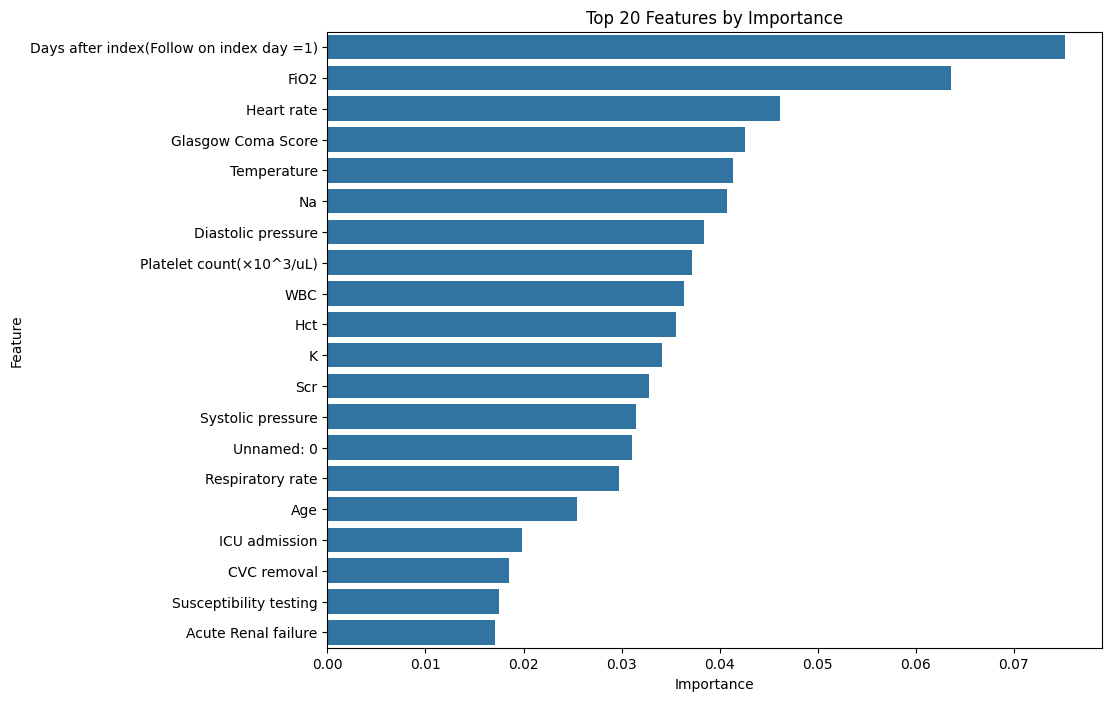

RandomForestClassifier(bootstrap=False, max_depth=10, random_state=42)

In [5]:
# Analyze feature importances
feature_importances = pd.Series(rf_model.feature_importances_, index=train_X.columns)
important_features = feature_importances[feature_importances > 0.01].index.tolist()

print(f"Selected important features: {important_features}")

# Create a dataframe of feature importances for visualization
feature_importances_df = pd.DataFrame({'Feature': train_X.columns, 'Importance': rf_model.feature_importances_})
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Display the top important features
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df.head(20))
plt.title('Top 20 Features by Importance')
plt.show()

# Re-train the model using only important features
X_train_important = X_train_imputed[important_features]
X_val_important = X_val_imputed[important_features]

rf_model.fit(X_train_important, y_train_imputed)

### Evaluate the Random Forest Model

In [6]:
# Predict on validation set
y_pred_rf = rf_model.predict(X_val_important)
y_prob_rf = rf_model.predict_proba(X_val_important)[:, 1]

# Evaluate the Random Forest model
f1_rf = f1_score(y_val_imputed, y_pred_rf)
mcc_rf = matthews_corrcoef(y_val_imputed, y_pred_rf)
auroc_rf = roc_auc_score(y_val_imputed, y_prob_rf)

print(f'RF F1 Score: {f1_rf}')
print(f'RF MCC: {mcc_rf}')
print(f'RF AUROC: {auroc_rf}')


RF F1 Score: 0.6341463414634146
RF MCC: 0.5214725259773693
RF AUROC: 0.9137803979366248


## Gradient Boosting Machine (GBM)

In [7]:
# Define the GBM classifier with specified hyperparameters
gbm_model = HistGradientBoostingClassifier(
    l2_regularization=1,
    learning_rate=0.1,
    max_depth=None,
    max_iter=100,
    min_samples_leaf=50,
    random_state=42
)

# Train the GBM model
gbm_model.fit(X_train_imputed, y_train_imputed)

# Predict on validation set
y_pred_gbm = gbm_model.predict(X_val_imputed)
y_prob_gbm = gbm_model.predict_proba(X_val_imputed)[:, 1]

### Evaluate the GBM model

In [8]:
f1_gbm = f1_score(y_val_imputed, y_pred_gbm)
mcc_gbm = matthews_corrcoef(y_val_imputed, y_pred_gbm)
auroc_gbm = roc_auc_score(y_val_imputed, y_prob_gbm)

print(f'GBM F1 Score: {f1_gbm}')
print(f'GBM MCC: {mcc_gbm}')
print(f'GBM AUROC: {auroc_gbm}')

GBM F1 Score: 0.723404255319149
GBM MCC: 0.6126360516280949
GBM AUROC: 0.9240972733971997


## Comparing the two models

           Model  F1 Score       MCC     AUROC
0  Random Forest  0.634146  0.521473  0.913780
1            GBM  0.723404  0.612636  0.924097


<Figure size 1200x600 with 0 Axes>

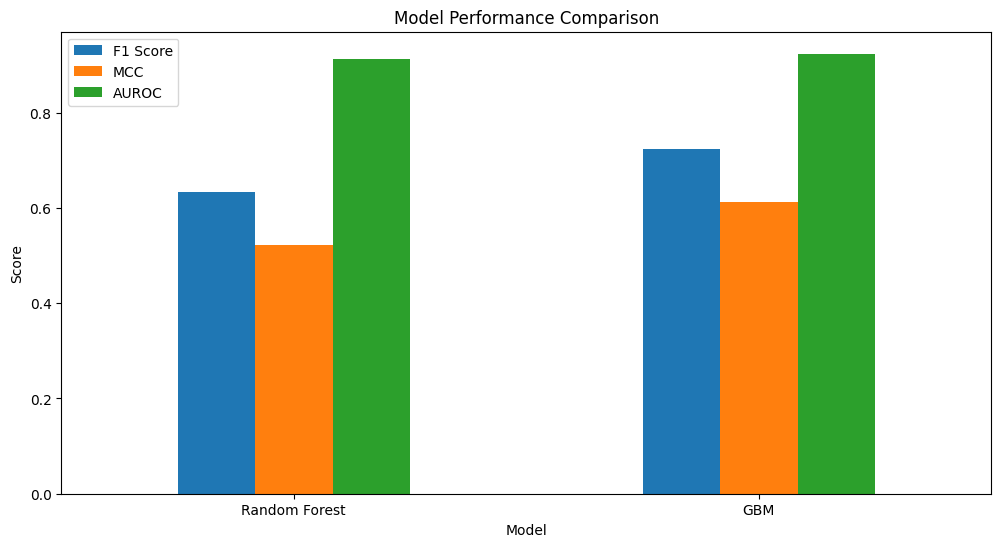

In [9]:
## Compare models
comparison_df = pd.DataFrame({
    'Model': ['Random Forest', 'GBM'],
    'F1 Score': [f1_rf, f1_gbm],
    'MCC': [mcc_rf, mcc_gbm],
    'AUROC': [auroc_rf, auroc_gbm]
})

print(comparison_df)

# Plot comparison
plt.figure(figsize=(12, 6))
comparison_df.set_index('Model').plot(kind='bar', figsize=(12, 6))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.show()



## Select the best model and save results

Best model is GBM. Results saved to test_results.xlsx


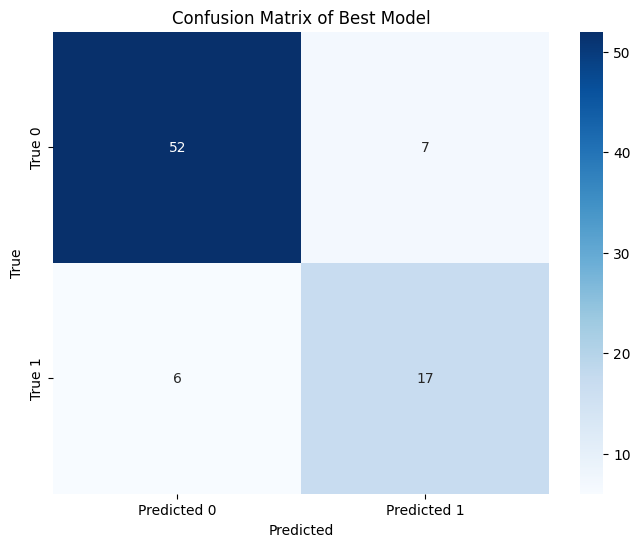

In [10]:
# Load the test data
test_X = pd.read_excel('./test_X.xlsx')

# Preprocessing for test data
test_X.columns = [col.strip() for col in test_X.columns]
test_X[numeric_features] = scaler.fit_transform(test_X[numeric_features])
test_X_imputed = pd.DataFrame(imputer.transform(test_X), columns=test_X.columns)


if f1_rf > f1_gbm:
    best_model = rf_model
    test_X_important = test_X_imputed[important_features]
    test_pred = best_model.predict(test_X_important)
    test_prob = best_model.predict_proba(test_X_important)[:, 1]
    results = pd.DataFrame({'ID': test_X.index+1, 'prediction': test_pred, 'probability': test_prob})
    results.to_excel('./test_results.xlsx', index=False)
    print("Best model is Random Forest. Results saved to test_results.xlsx")
else:
    best_model = gbm_model
    test_pred = best_model.predict(test_X_imputed)
    test_prob = best_model.predict_proba(test_X_imputed)[:, 1]
    results = pd.DataFrame({'ID': test_X.index+1, 'prediction': test_pred, 'probability': test_prob})
    results.to_excel('./test_results.xlsx', index=False)
    print("Best model is GBM. Results saved to test_results.xlsx")

# Plot confusion matrix
conf_matrix = confusion_matrix(y_val_imputed, best_model.predict(X_val_important if f1_rf > f1_gbm else X_val_imputed))
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'])
plt.title('Confusion Matrix of Best Model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()